2023-10-24 22:00:20.158721: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 22:00:21.228639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/breno/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-24 22:00:36.752024: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with 

Dl Completed...: 100%|██████████| 5/5 [00:03<00:00,  1.57 file/s]
2023-10-24 22:00:42.144518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 22:00:42.372367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 22:00:42.372482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 22:00:42.373446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built with

Dataset mnist downloaded and prepared to /home/breno/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


converting test: 100%|██████████| 10000/10000 [00:02<00:00, 4416.22it/s]



The initial batch size is 20 (10 classes * 2 examples per class) with 0 augmentations


indexing classes: 100%|██████████| 70000/70000 [00:00<00:00, 3114736.37it/s]


Distance metric automatically set to cosine use the distance arg to override.
Epoch 1/5


2023-10-24 22:01:05.334583: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-10-24 22:01:49.006742: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f18e00bd3d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-24 22:01:49.006806: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2023-10-24 22:01:49.056355: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-24 22:01:49.259088: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 [==============================] - 61s 11ms/step - loss: 0.1253
Warmup complete
Epoch 2/5
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0570
Epoch 3/5
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0403
Epoch 4/5
1000/1000 [==============================] - 12s 12ms/step - loss: 0.0346
Epoch 5/5
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0293
[Indexing 100 points]
|-Computing embeddings
4/4 [==============================] - 0s 31ms/step
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.
1/1 [==============================] - 0s 63ms/step



0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


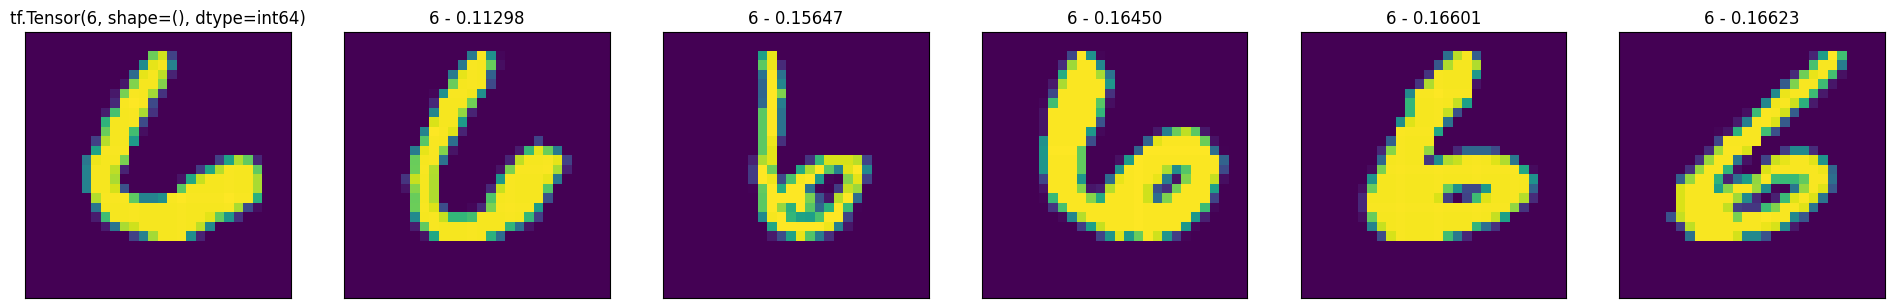

In [1]:
from tensorflow.keras import layers

# Embedding output layer with L2 norm
from tensorflow_similarity.layers import MetricEmbedding 
# Specialized metric loss   
from tensorflow_similarity.losses import MultiSimilarityLoss 
# Sub classed keras Model with support for indexing
from tensorflow_similarity.models import SimilarityModel
# Data sampler that pulls datasets directly from tf dataset catalog
from tensorflow_similarity.samplers import TFDatasetMultiShotMemorySampler
# Nearest neighbor visualizer
from tensorflow_similarity.visualization import viz_neigbors_imgs


# Data sampler that generates balanced batches from MNIST dataset
sampler = TFDatasetMultiShotMemorySampler(dataset_name='mnist', classes_per_batch=10)

# Build a Similarity model using standard Keras layers
inputs = layers.Input(shape=(28, 28, 1))
x = layers.Rescaling(1/255)(inputs)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = MetricEmbedding(64)(x)

# Build a specialized Similarity model
model = SimilarityModel(inputs, outputs)

# Train Similarity model using contrastive loss
model.compile('adam', loss=MultiSimilarityLoss())
model.fit(sampler, epochs=5)

# Index 100 embedded MNIST examples to make them searchable
sx, sy = sampler.get_slice(0,100)
model.index(x=sx, y=sy, data=sx)

# Find the top 5 most similar indexed MNIST examples for a given example
qx, qy = sampler.get_slice(3713, 1)
nns = model.single_lookup(qx[0])

# Visualize the query example and its top 5 neighbors
viz_neigbors_imgs(qx[0], qy[0], nns)